In [1]:
import os
from datetime import date
import pandas as pd
import empyrical as empy
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_score, accuracy_score, confusion_matrix, 
    mean_squared_error, recall_score, f1_score
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_kpi2ret(result_excel_name, start=None, end=None):
    hist = pd.read_excel(result_excel_name, index_col=0, sheet_name='History')
    hist.index = pd.to_datetime(hist.index)
    balance = hist['Balance']
    balance_ = pd.concat([pd.Series(1e9),balance])
    ret = balance_.pct_change().ffill().dropna()
    ret.index = pd.to_datetime(ret.index)
    if start is not None:
        ret = ret[start:]
    if end is not None:
        ret = ret[:end]
    return ret


def cal_metric(y_true, y_pred):

    if isinstance(y_pred, pd.DataFrame):
        prec_ser = pd.Series(index=y_pred.columns, name='precision')
        acccc_ser = pd.Series(index=y_pred.columns, name='accuracy')
        recall_ser = pd.Series(index=y_pred.columns, name='recall')
        recall0_ser = pd.Series(index=y_pred.columns, name='recall0')
        f1_score_ser = pd.Series(index=y_pred.columns, name='f1_score')
        f0_score_ser = pd.Series(index=y_pred.columns, name='f0_score')
        for col in y_pred.columns:
            # print("   *********************************  ", col)
            if isinstance(y_true, pd.DataFrame):
                tmp_y_true = y_true[col]
            else:
                tmp_y_true = y_true.copy()
            prec_ser[col], acccc_ser[col], recall_ser[col], recall0_ser[col], f1_score_ser[col], f0_score_ser[col] = cal_metric(
                tmp_y_true, y_pred[col])
        return prec_ser, acccc_ser, recall_ser, recall0_ser, f1_score_ser, f0_score_ser

    y_true = y_true.reindex(y_pred.index)
    tmp = pd.concat([y_true, y_pred], axis=1).dropna()
    y_true = tmp.iloc[:, 0]
    y_pred = tmp.iloc[:, -1]
    # print("y_pred\n", y_pred)
    # print("y_true\n", y_true)
    # pd.concat([y_proba, y_pred, y_pctch, y_true, ydelta_true], axis=1).to_csv("./tmp/{}.csv".format(y_pctch.name))

    try:
        prec = precision_score(y_true=y_true, y_pred=y_pred)
        acccc = accuracy_score(y_true=y_true, y_pred=y_pred)
    except Exception as e:
        print(e)
        prec = 0
        acccc = 0

    try:
        recall = recall_score(y_true=y_true, y_pred=y_pred)
        recall0 = recall_score(y_true=y_true, y_pred=y_pred, pos_label=0)
    except Exception as e:
        print(e)
        recall = 0
        recall0 = 0

    try:
        f1score = f1_score(y_true=y_true, y_pred=y_pred)
        f0score = f1_score(y_true=y_true, y_pred=y_pred, pos_label=0)
    except Exception as e:
        print(e)
        f1score = 0
        f0score = 0
    # print("mse, mse_proba, msefullscore, msefullscore_ret, prec, acccc, recall, recall0")
    # print(mse, mse_proba, msefullscore, msefullscore_ret, prec, acccc, recall, recall0)
    return prec, acccc, recall, recall0, f1score, f0score

In [3]:
base_no3vote = './result/2022/MPT_kpi/1.5.1b/'
mpt_v = '151b'
start = '2008'
end = '2022-07'
client_ret = {}
for result_excel_name in os.listdir(base_no3vote):
    if result_excel_name.endswith('.xlsx'):
        client = result_excel_name.replace('.xlsx', '').split('_')[-1]
        ret = read_kpi2ret(os.path.join(base_no3vote, result_excel_name), start, end)
        ret.name = client
        client_ret[client] = ret

In [4]:
preds_csv = [
    ('./data/data_price/data_price_xxz.csv', [0], ['xxz'], [1, 5, 10, 21]),
    ('./data/data_price/data_price_xzz.csv', [0], ['xzz'], [1, 5, 10, 21]),
    ('./data/data_price/data_price(13ETFs).csv', None, None, [1, 5, 10, 21])
]


preds = pd.DataFrame()
rets = pd.DataFrame()
for f, col, col_name, pps in preds_csv:
    print(f, col, col_name, pps)
    df = pd.read_csv(f, index_col=0)
    df.index = pd.to_datetime(df.index)
    if col is not None:
        df = df.iloc[:, col]
        df.columns = col_name

    for pp in pps:
        df_pct = df.pct_change(pp)
        df_pct.columns = ["{}_pp{}".format(c, pp) for c in df_pct.columns]
        rets = pd.concat([rets, df_pct], axis=1)
        df_pct = (df_pct>=0).astype(int)
        df_pct.columns = ["{}_pp{}".format(c, pp) for c in df_pct.columns]
        preds = pd.concat([preds, df_pct], axis=1)

preds = preds.dropna()
rets = rets.dropna()
display(preds.columns)
preds

./data/data_price/data_price_xxz.csv [0] ['xxz'] [1, 5, 10, 21]
./data/data_price/data_price_xzz.csv [0] ['xzz'] [1, 5, 10, 21]
./data/data_price/data_price(13ETFs).csv None None [1, 5, 10, 21]


Index(['xxz_pp1_pp1', 'xxz_pp5_pp5', 'xxz_pp10_pp10', 'xxz_pp21_pp21',
       'xzz_pp1_pp1', 'xzz_pp5_pp5', 'xzz_pp10_pp10', 'xzz_pp21_pp21',
       'DBC_pp1_pp1', 'EEM_pp1_pp1', 'EWJ_pp1_pp1', 'GLD_pp1_pp1',
       'IYR_pp1_pp1', 'LQD_pp1_pp1', 'QQQ_pp1_pp1', 'SPY_pp1_pp1',
       'TIP_pp1_pp1', 'TLT_pp1_pp1', 'VGK_pp1_pp1', 'VTI_pp1_pp1',
       'VYM_pp1_pp1', 'DBC_pp5_pp5', 'EEM_pp5_pp5', 'EWJ_pp5_pp5',
       'GLD_pp5_pp5', 'IYR_pp5_pp5', 'LQD_pp5_pp5', 'QQQ_pp5_pp5',
       'SPY_pp5_pp5', 'TIP_pp5_pp5', 'TLT_pp5_pp5', 'VGK_pp5_pp5',
       'VTI_pp5_pp5', 'VYM_pp5_pp5', 'DBC_pp10_pp10', 'EEM_pp10_pp10',
       'EWJ_pp10_pp10', 'GLD_pp10_pp10', 'IYR_pp10_pp10', 'LQD_pp10_pp10',
       'QQQ_pp10_pp10', 'SPY_pp10_pp10', 'TIP_pp10_pp10', 'TLT_pp10_pp10',
       'VGK_pp10_pp10', 'VTI_pp10_pp10', 'VYM_pp10_pp10', 'DBC_pp21_pp21',
       'EEM_pp21_pp21', 'EWJ_pp21_pp21', 'GLD_pp21_pp21', 'IYR_pp21_pp21',
       'LQD_pp21_pp21', 'QQQ_pp21_pp21', 'SPY_pp21_pp21', 'TIP_pp21_pp21',
       'TL

,xxz_pp1_pp1,xxz_pp5_pp5,xxz_pp10_pp10,xxz_pp21_pp21,xzz_pp1_pp1,xzz_pp5_pp5,xzz_pp10_pp10,xzz_pp21_pp21,DBC_pp1_pp1,EEM_pp1_pp1,...,GLD_pp21_pp21,IYR_pp21_pp21,LQD_pp21_pp21,QQQ_pp21_pp21,SPY_pp21_pp21,TIP_pp21_pp21,TLT_pp21_pp21,VGK_pp21_pp21,VTI_pp21_pp21,VYM_pp21_pp21
1999-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,1,1,0,0,0,0,0
2000-01-03,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,...,0,0,0,1,1,0,0,0,0,0
2000-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
2000-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
2000-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-24,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,...,1,1,0,1,1,0,0,1,1,1
2022-08-25,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,1,...,1,1,0,1,1,0,0,0,1,1
2022-08-26,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,1,1
2022-08-29,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
rets

,xxz_pp1,xxz_pp5,xxz_pp10,xxz_pp21,xzz_pp1,xzz_pp5,xzz_pp10,xzz_pp21,DBC_pp1,EEM_pp1,...,GLD_pp21,IYR_pp21,LQD_pp21,QQQ_pp21,SPY_pp21,TIP_pp21,TLT_pp21,VGK_pp21,VTI_pp21,VYM_pp21
2006-12-18,-0.002984,-0.004104,-0.008846,0.013865,-0.002979,-0.002659,-0.006702,0.024808,-0.041144,-0.006954,...,-0.004404,0.036285,0.004387,-0.006998,0.011184,0.000803,0.003578,0.037004,0.015472,0.025565
2006-12-19,0.001087,-0.002230,-0.009359,0.011560,0.001219,-0.000538,-0.007573,0.022828,0.011851,-0.006294,...,0.000324,0.029557,0.000930,-0.010158,0.012819,-0.001904,-0.003446,0.044076,0.017424,0.027305
2006-12-20,0.000575,0.000142,-0.004273,0.011705,0.000682,0.001582,-0.002380,0.017630,0.002019,-0.003122,...,-0.002428,-0.006804,0.000930,-0.015769,0.011673,-0.002805,-0.005106,0.039791,0.016406,0.026305
2006-12-21,-0.001041,-0.004313,-0.003685,0.007742,-0.001327,-0.003846,-0.002131,0.010694,-0.010077,-0.001790,...,-0.014293,-0.032864,0.002135,-0.024072,0.006968,-0.002200,-0.002547,0.030762,0.009833,0.024356
2006-12-22,-0.003157,-0.005516,-0.003209,0.002080,-0.003191,-0.005592,-0.001672,0.005028,0.007736,0.003586,...,-0.013600,-0.043071,-0.002133,-0.040241,-0.001206,-0.007592,-0.011828,-0.004138,-0.003722,0.017026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-24,0.001080,-0.003210,-0.009581,0.007713,-0.000088,-0.004353,-0.014598,-0.003396,0.010518,-0.000251,...,0.020058,0.023862,-0.017843,0.070116,0.058277,-0.002766,-0.053286,0.003208,0.061414,0.040657
2022-08-25,0.004122,-0.003699,-0.000874,0.004370,0.004580,-0.004432,-0.003203,-0.004376,-0.014126,0.021635,...,0.012866,0.031033,-0.014286,0.044881,0.046055,-0.006011,-0.034669,-0.011056,0.049238,0.040943
2022-08-26,-0.004737,-0.001152,-0.011992,-0.008796,-0.000598,0.003428,-0.009892,-0.012429,0.004148,-0.014775,...,-0.011489,-0.026620,-0.028249,-0.007650,-0.001872,-0.017511,-0.035074,-0.045813,0.001425,0.005965
2022-08-29,-0.001792,0.001033,-0.011619,-0.013894,-0.001837,0.004012,-0.008354,-0.015991,0.014645,-0.006248,...,-0.013650,-0.040847,-0.037693,-0.035028,-0.022719,-0.026220,-0.040450,-0.060043,-0.019248,-0.005358


In [6]:
client_ret_df = pd.concat(client_ret.values(), keys=client_ret.keys(), axis=1)
df = pd.concat([client_ret_df, rets], axis=1)
df_corr = df.corr()[client_ret_df.columns]
df_corr['mean'] = df_corr.mean(axis=1)
df_corr.sort_values('mean', ascending=False)

,agg,con,ficon,mod,mean
mod,0.973818,0.905785,0.918660,1.000000,0.949566
agg,1.000000,0.878259,0.921483,0.973818,0.943390
ficon,0.921483,0.914645,1.000000,0.918660,0.938697
con,0.878259,1.000000,0.914645,0.905785,0.924672
xxz_pp1,0.798734,0.820337,0.829755,0.815327,0.816038
...,...,...,...,...,...
VTI_pp21,0.059811,0.070713,0.078658,0.057873,0.066764
GLD_pp21,0.057471,0.065788,0.060208,0.052440,0.058977
IYR_pp21,0.052453,0.054301,0.073191,0.046917,0.056715
VYM_pp21,0.048369,0.060178,0.065279,0.048671,0.055624


In [7]:
## sliding correlation
df = df.dropna()
df

,agg,con,ficon,mod,xxz_pp1,xxz_pp5,xxz_pp10,xxz_pp21,xzz_pp1,xzz_pp5,...,GLD_pp21,IYR_pp21,LQD_pp21,QQQ_pp21,SPY_pp21,TIP_pp21,TLT_pp21,VGK_pp21,VTI_pp21,VYM_pp21
2008-01-02,0.021396,0.005236,0.009580,0.014142,0.010212,0.022039,0.032919,0.025690,0.013264,0.025172,...,0.097517,-0.069551,-0.005065,-0.017540,-0.025091,-0.000562,0.000000,-0.054548,-0.023954,-0.041049
2008-01-03,0.004646,0.001777,0.002535,0.003119,-0.000287,0.020732,0.029109,0.020871,0.001630,0.025777,...,0.093127,-0.093080,-0.004426,-0.005110,-0.019095,0.003470,-0.005277,-0.048104,-0.019170,-0.033843
2008-01-04,-0.008659,-0.004346,-0.006457,-0.005822,-0.005464,0.011808,0.016453,0.015043,-0.004124,0.018163,...,0.072166,-0.098242,0.003294,-0.044800,-0.034504,0.004979,-0.004961,-0.065796,-0.039209,-0.044457
2008-01-07,-0.003819,-0.000517,-0.002890,-0.002562,-0.001669,0.005024,0.017242,0.019384,-0.003093,0.009932,...,0.078087,-0.115053,0.005857,-0.066111,-0.051206,0.015573,0.011430,-0.075060,-0.052889,-0.050143
2008-01-08,0.002096,0.000090,0.001173,0.001404,-0.002045,0.000676,0.013557,0.012947,0.001260,0.008875,...,0.093360,-0.176789,0.011421,-0.103211,-0.079701,0.019430,0.019183,-0.089194,-0.083121,-0.077486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,-0.000750,-0.000930,0.000184,0.002283,-0.000948,0.011999,0.013325,-0.000103,-0.001091,0.010984,...,-0.058910,0.037033,0.024645,0.054134,0.046315,0.003295,0.028474,0.028648,0.048075,0.033887
2022-07-26,-0.002205,-0.001096,-0.000631,-0.001233,-0.000770,0.010591,0.018369,-0.004090,0.000415,0.012544,...,-0.059086,0.016057,0.023254,-0.000815,0.002077,0.002339,0.043710,-0.020699,0.002715,0.002323
2022-07-27,0.009416,0.004479,0.005019,0.011265,0.007464,0.018321,0.019738,0.008650,0.005569,0.018370,...,-0.048440,0.026857,0.039604,0.049102,0.032039,0.016054,0.046774,0.005559,0.032222,0.012269
2022-07-28,0.009641,0.004763,0.005366,0.007475,0.008483,0.020444,0.034325,0.017245,0.007552,0.019451,...,-0.035255,0.073663,0.048510,0.092650,0.066781,0.030032,0.050214,0.021145,0.067688,0.029638


In [8]:
lookback = [5, 10, 21, 21*3, 21*6, 252] # days

lb_corr = {}
for lb in lookback:
    df_corr = df.rolling(lb).corr()[client_ret_df.columns]
    df_corr['mean'] = df_corr.mean(axis=1)
    lb_corr[lb] = df_corr

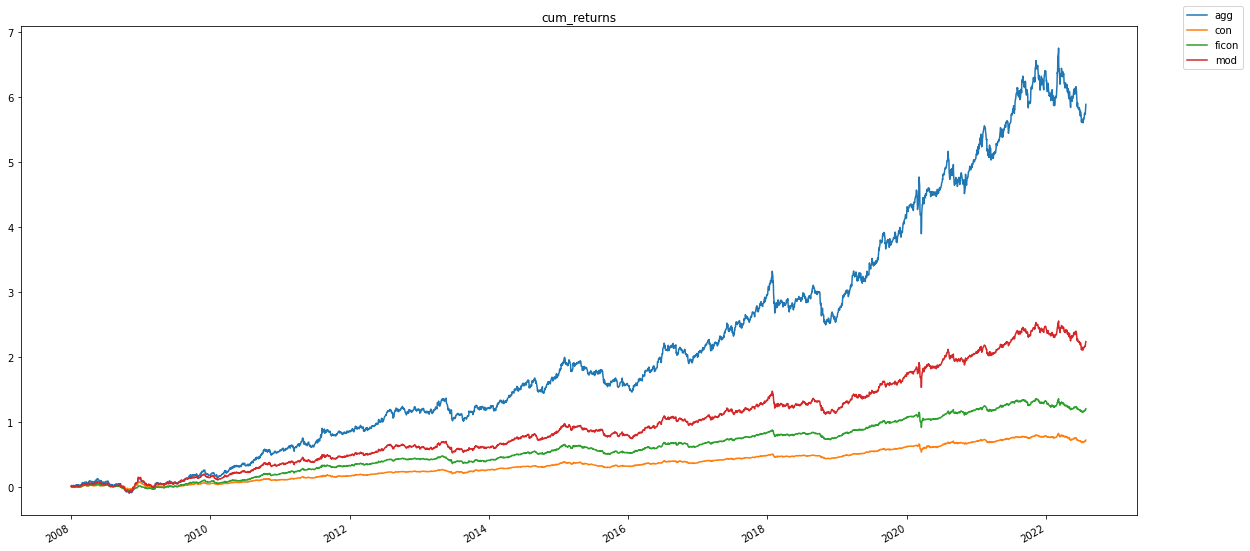

In [16]:
cum_returns = empy.cum_returns(client_ret_df)
cum_returns.plot(figsize=(20, 10), title='cum_returns').legend(bbox_to_anchor=(1.1, 1.05))

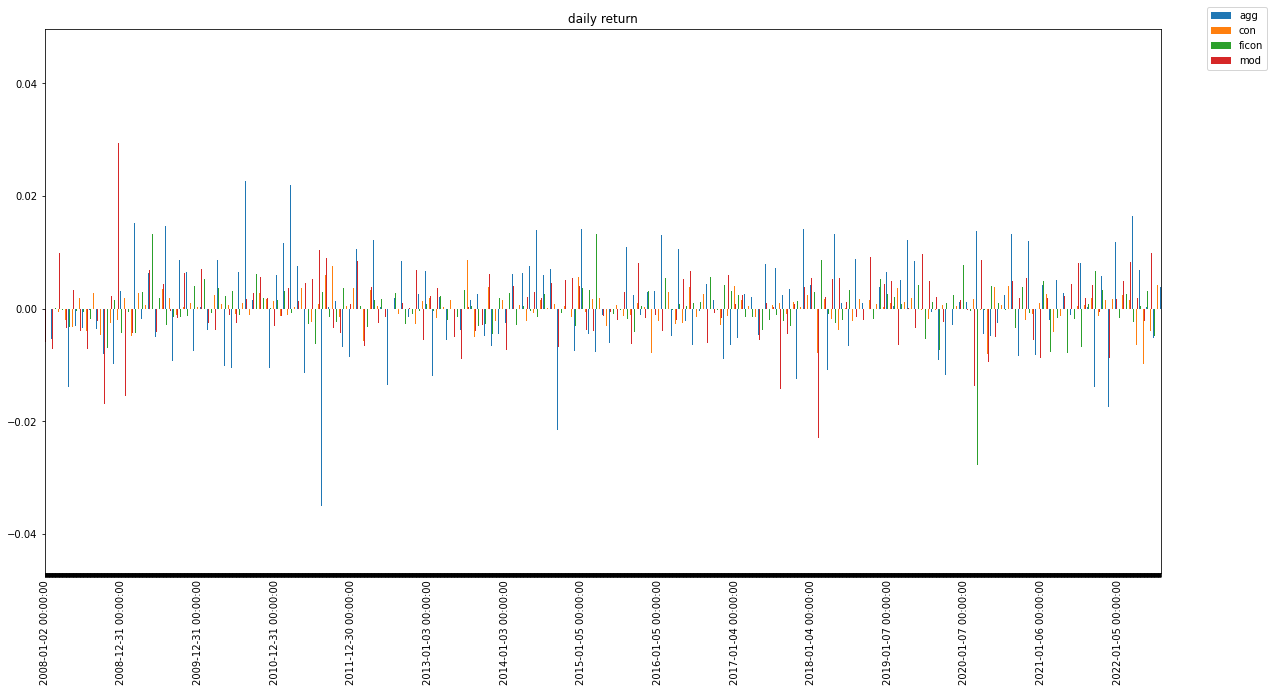

In [15]:
client_ret_df.index = pd.to_datetime(client_ret_df.index)
ax = client_ret_df.plot.bar(figsize=(20, 10), title='daily return')
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 252*3) != 0:
        t.set_visible(False)
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [ ]:
# pt.plot()
for lb, df_corr in lb_corr.items():
    df_corr.index.names = ['date', 'case']
    df_corr = df_corr.reset_index()
    pt = df_corr.pivot_table(index='date', values='mean', columns='case')
    pt_pct = pt.pct_change()

    for asset in ['DBC', 'EEM', 'IYR', 'TLT', 'VTI', 'SPY', 'QQQ', 'VGK', 'EWJ', 'GLD', 'LQD', 'VYM', 'TIP', 'xxz', 'xzz']:
        # pt.loc[:, pt.columns.str.startswith(asset)].plot(figsize=(12, 10), title='{} lookback {} days'.format(asset, lb))
        pt_pct.loc[:, "{}_pp10".format(asset)].plot(figsize=(12, 10), title='{} lookback {} days'.format(asset, lb))
        plt.show()
        plt.clf()
        for yy in range(2008, 2023):
            # pt.loc[str(yy), pt.columns.str.startswith(asset)].plot(figsize=(12, 10), title='{} lookback {} days'.format(asset, lb))
            pt_pct.loc[str(yy), "{}_pp10".format(asset)].plot(figsize=(12, 10), title='{} lookback {} days'.format(asset, lb))
            plt.show()
            plt.clf()
            break
        break
    break


In [1]:
# pt.plot()
# cum_returns = empy.cum_returns(client_ret_df)
# for yy in range(2008, 2023):
yy = 2008
if True:
    client_ret_yy = client_ret_df[str(yy)]
    cum_returns_yy = empy.cum_returns(client_ret_yy)

    fig, ax = plt.subplots(2, 1, figsize=(12, 20))
    fig.suptitle('{}'.format(yy))
            
    # ax2 = ax1.twinx()
    ax[0].plot(cum_returns_yy.index, cum_returns_yy.values, label=cum_returns_yy.columns)
    ax[0].set_ylabel('cum_returns')
    ax[0].legend(bbox_to_anchor=(1.1, 1.05))

    # dates = [time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(date)) for date in epochs]
    # ax[1].plot(client_ret_df.index, client_ret_df.values, label=client_ret_df.columns)
    # pd.concat([client_ret_df, pt[col]], axis=1).plot(kind='bar', ax=ax[1])
            
    # ttt = client_ret_df[str(yy)]
    # ttt.indx = ttt.index.astype(str)
    client_ret_yy.plot(kind='bar', ax=ax[1])
    ax[1].set_ylabel('daily return')
    # ax[1].set_xticks(["{}_{}".format(yy, i) for i in range(1, 13)])
    # ax[1].xaxis.set_major_formatter(DateFormatter("%Y"))
    ax[1].legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()
    plt.clf()

    for lb, df_corr in lb_corr.items():
        df_corr.index.names = ['date', 'case']
        df_corr = df_corr.reset_index()
        pt = df_corr.pivot_table(index='date', values='mean', columns='case')
        pt_pct = pt.pct_change()
    
        for col in pt.columns:
            fig, ax = plt.subplots(2, 1, figsize=(12, 20))
            fig.suptitle('{} {} lookback {} days'.format(col, yy, lb))

            ax[0].bar(pt[col][str(yy)].index, pt[col][str(yy)].values, label=col)
            ax[0].set_ylabel('correlation')
            ax[0].legend(bbox_to_anchor=(1.1, 1.05))

            ax[1].bar(pt_pct[str(yy)].index, pt_pct[str(yy)].values, label=col)
            ax[1].set_ylabel('correlation pct_change')
            ax[1].legend(bbox_to_anchor=(1.1, 1.05))
            plt.show()
            plt.clf()


    """
    for asset in ['DBC', 'EEM', 'IYR', 'TLT', 'VTI', 'SPY', 'QQQ', 'VGK', 'EWJ', 'GLD', 'LQD', 'VYM', 'TIP', 'xxz', 'xzz']:
        pt.loc[:, pt.columns.str.startswith(asset)].plot(figsize=(12, 10), title='{} lookback {} days'.format(asset, lb))
    """

NameError: name 'client_ret_df' is not defined

In [37]:
metrics4portfolio = {}
for client in client_ret.keys():
    portfolioY = (client_ret[client]>=0).astype(int)
    prec_ser, acccc_ser, recall_ser, recall0_ser, f1score_ser, f0score_ser = cal_metric(portfolioY, preds)
    metrics4portfolio[client] = pd.concat([acccc_ser, prec_ser, recall_ser, recall0_ser, f1score_ser, f0score_ser], axis=1)
metrics4portfolio_df = pd.concat(metrics4portfolio.values(), keys=metrics4portfolio.keys(), axis=1)
metrics4portfolio_df

agg                                                    \
               accuracy precision    recall   recall0  f1_score  f0_score   
xxz_pp1_pp1    0.846594  0.874621  0.845966  0.847385  0.860055  0.830268   
xxz_pp5_pp5    0.622343  0.653042  0.687531  0.540308  0.669843  0.558880   
xxz_pp10_pp10  0.590191  0.623235  0.668949  0.491077  0.645283  0.514839   
xxz_pp21_pp21  0.580381  0.607768  0.696333  0.434462  0.649043  0.478320   
xzz_pp1_pp1    0.860218  0.884152  0.862103  0.857846  0.872988  0.844593   
xzz_pp5_pp5    0.631063  0.660176  0.696333  0.548923  0.677772  0.568515   
xzz_pp10_pp10  0.596730  0.625835  0.687042  0.483077  0.655012  0.514754   
xzz_pp21_pp21  0.570572  0.598240  0.698289  0.409846  0.644404  0.458047   
DBC_pp1_pp1    0.593188  0.641393  0.612225  0.569231  0.626470  0.553395   
EEM_pp1_pp1    0.613896  0.662526  0.625917  0.598769  0.643701  0.578650   
EWJ_pp1_pp1    0.605177  0.651269  0.627384  0.577231  0.639103  0.564211   
GLD_pp1_pp1    0.625886  0.673733  0.637164  0.611692  0.654938  0.591491   
IYR_pp1_pp1    0.623433  0.668531  0.643032  0.598769  0.655533  0.584736   
LQD_pp1_pp1    0.724523  0.760060  0.738875  0.706462  0.749318  0.694285   
QQQ_pp1_pp1    0.626975  0.665200  0.665526  0.578462  0.665363  0.578640   
SPY_pp1_pp1    0.620436  0.661706  0.652323  0.580308  0.656981  0.575175   
TIP_pp1_pp1    0.731335  0.774495  0.730562  0.732308  0.751887  0.707071   
TLT_pp1_pp1    0.705722  0.750649  0.706601  0.704615  0.727960  0.679525   
VGK_pp1_pp1    0.622343  0.669583  0.636186  0.604923  0.652457  0.586516   
VTI_pp1_pp1    0.627793  0.668319  0.659169  0.588308  0.663712  0.583282   
VYM_pp1_pp1    0.597548  0.643145  0.623961  0.564308  0.633408  0.553911   
DBC_pp5_pp5    0.541417  0.593203  0.563325  0.513846  0.577878  0.498061   
EEM_pp5_pp5    0.557766  0.609553  0.574083  0.537231  0.591287  0.518255   
EWJ_pp5_pp5    0.553406  0.602216  0.584841  0.513846  0.593401  0.504684   
GLD_pp5_pp5    0.563215  0.611616  0.592176  0.526769  0.601739  0.516440   
IYR_pp5_pp5    0.563488  0.608845  0.605868  0.510154  0.607353  0.508589   
LQD_pp5_pp5    0.591281  0.635505  0.624939  0.548923  0.630178  0.543240   
QQQ_pp5_pp5    0.561035  0.598816  0.643032  0.457846  0.620137  0.480155   
SPY_pp5_pp5    0.573297  0.610216  0.648411  0.478769  0.628734  0.498398   
TIP_pp5_pp5    0.603815  0.649772  0.626895  0.574769  0.638128  0.562312   
TLT_pp5_pp5    0.568937  0.619268  0.587775  0.545231  0.603111  0.528324   
VGK_pp5_pp5    0.558311  0.606212  0.591687  0.516308  0.598862  0.508639   
VTI_pp5_pp5    0.574114  0.610856  0.649389  0.479385  0.629533  0.499199   
VYM_pp5_pp5    0.555313  0.597268  0.620049  0.473846  0.608445  0.485498   
DBC_pp10_pp10  0.528610  0.579425  0.561858  0.486769  0.570506  0.477657   
EEM_pp10_pp10  0.546322  0.597336  0.570171  0.516308  0.583438  0.501944   
EWJ_pp10_pp10  0.534060  0.583209  0.574083  0.483692  0.578610  0.478976   
GLD_pp10_pp10  0.538965  0.588738  0.572616  0.496615  0.580565  0.488203   
IYR_pp10_pp10  0.555858  0.599140  0.613203  0.483692  0.606090  0.490943   
LQD_pp10_pp10  0.566757  0.612124  0.607335  0.515692  0.609720  0.513166   
QQQ_pp10_pp10  0.556948  0.591365  0.663081  0.423385  0.625173  0.458361   
SPY_pp10_pp10  0.552589  0.588571  0.654768  0.424000  0.619907  0.456291   
TIP_pp10_pp10  0.559673  0.609944  0.581907  0.531692  0.595596  0.516746   
TLT_pp10_pp10  0.545777  0.600639  0.551589  0.538462  0.575070  0.512145   
VGK_pp10_pp10  0.538692  0.587649  0.577017  0.490462  0.582285  0.484941   
VTI_pp10_pp10  0.556131  0.592857  0.649389  0.438769  0.619837  0.466776   
VYM_pp10_pp10  0.541689  0.582915  0.623961  0.438154  0.602740  0.458467   
DBC_pp21_pp21  0.525613  0.577551  0.553545  0.490462  0.565293  0.477961   
EEM_pp21_pp21  0.528065  0.581383  0.546699  0.504615  0.563508  0.486358   
EWJ_pp21_pp21  0.526975  0.575996  0.572616  0.469538  0.574301  0.467811   
GLD_pp21_pp21  0

In [38]:
metrics4portfolio_df.groupby(level=1, axis=1).mean().sort_values('accuracy', ascending=False)

,accuracy,f0_score,f1_score,precision,recall,recall0
xzz_pp1_pp1,0.852589,0.836423,0.865845,0.875502,0.856406,0.847832
xxz_pp1_pp1,0.842779,0.826379,0.856347,0.869439,0.843651,0.841704
TIP_pp1_pp1,0.734469,0.711049,0.754374,0.775791,0.734115,0.734925
LQD_pp1_pp1,0.723842,0.694129,0.748291,0.757797,0.739027,0.704880
TLT_pp1_pp1,0.707084,0.681625,0.728771,0.750260,0.708485,0.705347
xzz_pp5_pp5,0.631063,0.569402,0.677273,0.658669,0.696964,0.548726
GLD_pp1_pp1,0.627520,0.594057,0.655884,0.673604,0.639077,0.613086
xxz_pp5_pp5,0.624796,0.562643,0.671478,0.653623,0.690343,0.542901
QQQ_pp1_pp1,0.623706,0.575790,0.661893,0.660679,0.663116,0.574468
VTI_pp1_pp1,0.623025,0.578775,0.658858,0.662370,0.655388,0.582592
